# **Experiment Notebook**



## Context


### 0. Import Packages

In [1]:
! pip install -r https://raw.githubusercontent.com/aso-uts/labs_datasets/main/36106-mlaa/requirements.txt

In [2]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from imblearn.over_sampling import ADASYN

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### 1.   Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the folder containing the CSV files
files = glob.glob("/content/drive/MyDrive/final/*.csv")

# Initialize an empty list to hold all DataFrames
dfs = []

# Iterate through each file path
for file_path in files:
    # Read the file into a DataFrame, without a header, using a pipe as a separator
    df = pd.read_csv(file_path, header=None, sep="|")
    # Add a new column containing the file name only (excluding the directory path)
    df['source_file'] = file_path.split('/')[-1]
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into one DataFrame
salesdata = pd.concat(dfs, ignore_index=True)

In [ ]:
salesdata.columns = salesdata.iloc[0]

In [ ]:
salesdata = salesdata[1:]

In [ ]:
salesdata = salesdata.rename(columns={'transactions_12.csv': 'source files'})

In [ ]:
salesdata['source files'].nunique()

In [ ]:
salesdata.to_csv('/content/drive/MyDrive/merged_transactions.csv', index=False)

In [3]:
transaction_file_path = '/content/drive/MyDrive/merged_transactions.csv'
customers_file_path = '/content/drive/MyDrive/customers.csv'

In [4]:
# Read transaction file with low_memory=False
transactions_df = pd.read_csv(transaction_file_path, low_memory=False)

# Read customers file with error handling
customers_df = pd.read_csv(customers_file_path, sep='|', quoting=csv.QUOTE_NONE, on_bad_lines='skip')

### 2. Explore Dataset

In [6]:
# Display the first few rows to understand the structure
print("Transactions DataFrame:")
transactions_df.head()

Transactions DataFrame:


,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,source files
0,4896331812335761701,149852234418,f3ec0819590302134f03ffdc2f44697f,1646060228,gas_transport,65.17,0,"Larson, Ryan and Huang",38.14343,-90.327335,transactions_12.csv
1,4896331812335761701,149852234418,c1607c993e41f2c3b42d72d1506bef7b,1644848624,gas_transport,47.58,0,Myers-Reed,39.119498,-90.760379,transactions_12.csv
2,4896331812335761701,149852234418,6f530db25d20fe351249a54491fd3fde,1645632153,gas_transport,64.43,0,Baker-Bullock,39.384368,-90.361517,transactions_12.csv
3,4896331812335761701,149852234418,6d11805f2acd938fec99376001afafe8,1645311286,gas_transport,82.47,0,Spencer-Hall,39.443567,-89.7524,transactions_12.csv
4,4896331812335761701,149852234418,605342f297c575cb1ccf2c08cad082ee,1641571926,gas_transport,50.28,0,"King, Rodriguez and Hancock",38.857278,-89.609525,transactions_12.csv


In [7]:
print("\nCustomers DataFrame:")
customers_df.head()


Customers DataFrame:


,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num
0,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03,888022315787
1,715-55-5575,4351161559407816183,Elaine,Fuller,F,310 Kendra Common Apt. 164,Leland,NC,28451,34.2680,-78.0578,27112,Professor Emeritus,1963-06-07,917558277935
2,167-48-5821,4192832764832,Michael,Cameron,M,05641 Robin Port,Cordova,SC,29039,33.4275,-80.8857,4215,International aid/development worker,1973-05-30,718172762479
3,406-83-7518,4238849696532874,Brandon,Williams,M,26916 Carlson Mountain,Birmingham,AL,35242,33.3813,-86.7046,493806,Seismic interpreter,1942-12-26,947268892251
4,697-93-1877,4514627048281480,Lisa,Hernandez,F,809 Burns Creek,Fargo,GA,31631,30.7166,-82.5801,559,Medical laboratory scientific officer,1939-05-22,888335239225


In [8]:
# Get a concise summary of the transactions DataFrame
print("Transactions DataFrame Info:")
transactions_df.info()

Transactions DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4261035 entries, 0 to 4261034
Data columns (total 11 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   cc_num        object
 1   acct_num      object
 2   trans_num     object
 3   unix_time     object
 4   category      object
 5   amt           object
 6   is_fraud      object
 7   merchant      object
 8   merch_lat     object
 9   merch_long    object
 10  source files  object
dtypes: object(11)
memory usage: 357.6+ MB


In [9]:
# Get a concise summary of the customers DataFrame
print("Customers DataFrame Info:")
customers_df.info()

Customers DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ssn       1000 non-null   object 
 1   cc_num    1000 non-null   int64  
 2   first     1000 non-null   object 
 3   last      1000 non-null   object 
 4   gender    1000 non-null   object 
 5   street    1000 non-null   object 
 6   city      1000 non-null   object 
 7   state     1000 non-null   object 
 8   zip       1000 non-null   int64  
 9   lat       1000 non-null   float64
 10  long      1000 non-null   float64
 11  city_pop  1000 non-null   int64  
 12  job       1000 non-null   object 
 13  dob       1000 non-null   object 
 14  acct_num  1000 non-null   int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 117.3+ KB


In [10]:
# Display descriptive statistics for numerical features in transactions data
print("Transactions DataFrame Description:")
transactions_df.describe()

Transactions DataFrame Description:


,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,source files
count,4261035,4261035,4261035,4261035,4261035,4261035,4261035,4261035,4261035,4261035,4261035
unique,984,984,4260905,4114753,15,81219,3,21978,3767590,4031686,132
top,347208496498560,11546128003,trans_num,unix_time,shopping_pos,1.02,0,Smith PLC,merch_lat,merch_long,transactions_40.csv
freq,10912,10912,131,131,420268,1879,4255870,5737,131,131,224902


In [11]:
# Display descriptive statistics for categorical features in transactions data
print("Transactions DataFrame Categorical Description:")
transactions_df.describe(include=['object', 'category'])

Transactions DataFrame Categorical Description:


,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,source files
count,4261035,4261035,4261035,4261035,4261035,4261035,4261035,4261035,4261035,4261035,4261035
unique,984,984,4260905,4114753,15,81219,3,21978,3767590,4031686,132
top,347208496498560,11546128003,trans_num,unix_time,shopping_pos,1.02,0,Smith PLC,merch_lat,merch_long,transactions_40.csv
freq,10912,10912,131,131,420268,1879,4255870,5737,131,131,224902


In [12]:
# Display descriptive statistics for numerical features in customers data
print("Customers DataFrame Description:")
customers_df.describe()

Customers DataFrame Description:


,cc_num,zip,lat,long,city_pop,acct_num
count,1.000000e+03,1000.00000,1000.000000,1000.000000,1.000000e+03,1.000000e+03
mean,3.656964e+17,51786.20900,37.422795,-92.505277,2.867058e+05,4.995849e+11
std,1.227337e+18,29933.13195,5.574397,17.510134,5.329632e+05,2.894933e+11
min,6.040027e+10,1571.00000,19.589300,-159.368300,1.050000e+02,2.348758e+09
25%,1.800353e+14,27528.25000,33.712500,-99.159475,2.022950e+04,2.620636e+11
50%,3.517359e+15,49016.00000,38.431750,-87.156600,6.728250e+04,4.915295e+11
75%,4.538733e+15,78599.00000,41.220300,-80.018850,2.499788e+05,7.571575e+11
max,4.986227e+18,99705.00000,64.780500,-68.244800,2.906700e+06,9.993899e+11


In [13]:
# Display descriptive statistics for categorical features in customers data
print("Customers DataFrame Categorical Description:")
customers_df.describe(include=['object', 'category'])

Customers DataFrame Categorical Description:


,ssn,first,last,gender,street,city,state,job,dob
count,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,367,487,2,1000,736,51,507,978
top,115-04-4507,Michael,Williams,F,863 Lawrence Valleys,Brooklyn,CA,Computer games developer,1962-11-16
freq,1,25,24,512,1,13,107,7,2


### 3. Convert Data Types and Handle Missing Values

In [5]:
# Convert relevant columns to appropriate types in transactions data
transactions_df['cc_num'] = pd.to_numeric(transactions_df['cc_num'], errors='coerce')
transactions_df['acct_num'] = pd.to_numeric(transactions_df['acct_num'], errors='coerce')
transactions_df['amt'] = pd.to_numeric(transactions_df['amt'], errors='coerce')
transactions_df['is_fraud'] = pd.to_numeric(transactions_df['is_fraud'], errors='coerce')
transactions_df['merch_lat'] = pd.to_numeric(transactions_df['merch_lat'], errors='coerce')
transactions_df['merch_long'] = pd.to_numeric(transactions_df['merch_long'], errors='coerce')

# Convert unix_time to datetime
transactions_df['unix_time'] = pd.to_datetime(transactions_df['unix_time'], unit='s', errors='coerce')

# Check for missing values after conversion
print("\nMissing Values in Transactions Data after type conversion:")
print(transactions_df.isnull().sum())

# Handle missing values (example: drop rows with missing values)
transactions_df = transactions_df.dropna(subset=['cc_num', 'acct_num', 'unix_time', 'amt', 'is_fraud', 'merch_lat', 'merch_long'])

# Confirm that the data types have been changed and there are no more missing values
print("\nTransactions DataFrame Info after type conversion and handling missing values:")
transactions_df.info()


Missing Values in Transactions Data after type conversion:
cc_num          131
acct_num        131
trans_num         0
unix_time       131
category          0
amt             131
is_fraud        131
merchant          0
merch_lat       131
merch_long      131
source files      0
dtype: int64

Transactions DataFrame Info after type conversion and handling missing values:
<class 'pandas.core.frame.DataFrame'>
Index: 4260904 entries, 0 to 4261034
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   cc_num        float64       
 1   acct_num      float64       
 2   trans_num     object        
 3   unix_time     datetime64[ns]
 4   category      object        
 5   amt           float64       
 6   is_fraud      float64       
 7   merchant      object        
 8   merch_lat     float64       
 9   merch_long    float64       
 10  source files  object        
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 390.1+ MB


In [6]:
# Merge transactions_df with customers_df on 'cc_num'
merged_df = pd.merge(transactions_df, customers_df, on=['acct_num', 'cc_num'])

merged_df = merged_df.sort_values(by='unix_time')

# Display the first few rows of the merged DataFrame
print("Merged DataFrame:")
merged_df.head()

# Check for missing values in the merged DataFrame
print("\nMissing Values in Merged DataFrame:")
print(merged_df.isnull().sum())

# Confirm that the merge was successful and the DataFrame contains the expected number of rows and columns
print("\nMerged DataFrame Info:")
merged_df.info()

Merged DataFrame:

Missing Values in Merged DataFrame:
cc_num          0
acct_num        0
trans_num       0
unix_time       0
category        0
amt             0
is_fraud        0
merchant        0
merch_lat       0
merch_long      0
source files    0
ssn             0
first           0
last            0
gender          0
street          0
city            0
state           0
zip             0
lat             0
long            0
city_pop        0
job             0
dob             0
dtype: int64

Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4108383 entries, 1998358 to 2960254
Data columns (total 24 columns):
 #   Column        Dtype         
---  ------        -----         
 0   cc_num        float64       
 1   acct_num      float64       
 2   trans_num     object        
 3   unix_time     datetime64[ns]
 4   category      object        
 5   amt           float64       
 6   is_fraud      float64       
 7   merchant      object        
 8   merch_lat     flo

### 4. Perform EDA

In [76]:
# Display basic statistics for numeric columns
print("Basic Statistics for Numeric Columns:")
merged_df.describe()

Basic Statistics for Numeric Columns:


,cc_num,acct_num,unix_time,amt,is_fraud,merch_lat,merch_long,zip,lat,long,city_pop
count,4.108383e+06,4.108383e+06,4108383,4.108383e+06,4.108383e+06,4.108383e+06,4.108383e+06,4.108383e+06,4.108383e+06,4.108383e+06,4.108383e+06
mean,2.429927e+17,4.948025e+11,2021-05-06 04:40:27.965741312,6.911735e+01,1.178809e-03,3.734163e+01,-9.243195e+01,5.190168e+04,3.734146e+01,-9.243177e+01,3.081475e+05
min,6.040027e+10,2.348758e+09,2018-12-31 13:00:48,1.000000e+00,0.000000e+00,1.859001e+01,-1.603677e+02,1.571000e+03,1.958930e+01,-1.593683e+02,1.050000e+02
25%,1.800322e+14,2.581163e+11,2020-04-22 12:30:56,9.130000e+00,0.000000e+00,3.365557e+01,-9.883251e+01,2.737100e+04,3.371690e+01,-9.867220e+01,1.991400e+04
50%,3.516698e+15,4.734608e+11,2021-07-17 07:21:36,4.459000e+01,0.000000e+00,3.820411e+01,-8.735014e+01,4.930100e+04,3.824200e+01,-8.762230e+01,6.873300e+04
75%,4.491342e+15,7.601677e+11,2022-06-11 07:19:28,8.172000e+01,0.000000e+00,4.120624e+01,-7.963282e+01,7.866500e+04,4.092180e+01,-7.990930e+01,2.475300e+05
max,4.983666e+18,9.993899e+11,2022-12-31 12:58:40,4.130053e+04,1.000000e+00,6.577610e+01,-6.724632e+01,9.970500e+04,6.478050e+01,-6.824480e+01,2.906700e+06
std,1.022969e+18,2.898354e+11,NaN,1.616018e+02,3.431355e-02,5.533821e+00,1.737291e+01,2.986400e+04,5.503639e+00,1.736302e+01,5.772624e+05


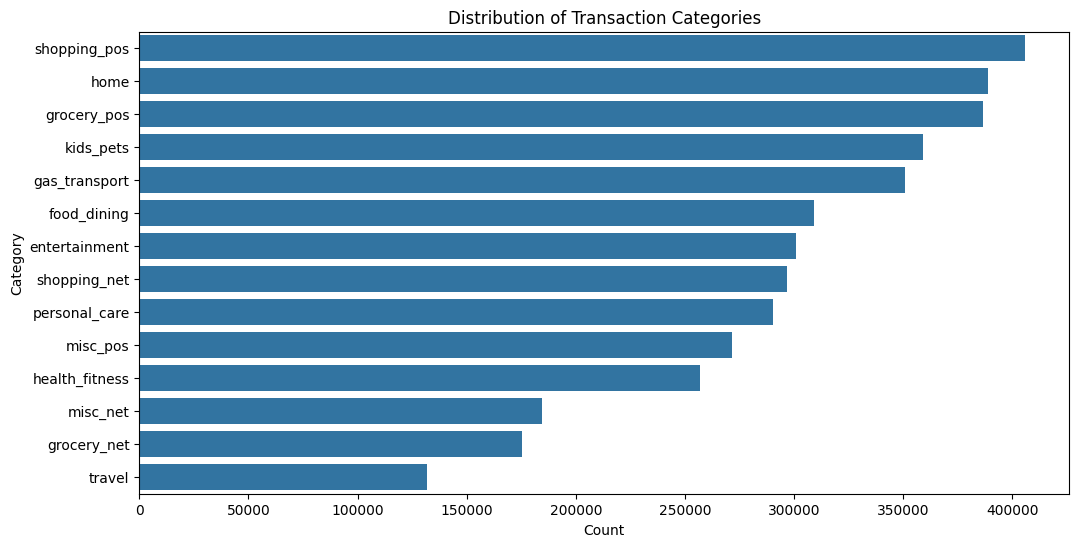

In [77]:
# Plot the distribution of categories
plt.figure(figsize=(12, 6))
sns.countplot(y=merged_df['category'], order=merged_df['category'].value_counts().index)
plt.title('Distribution of Transaction Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

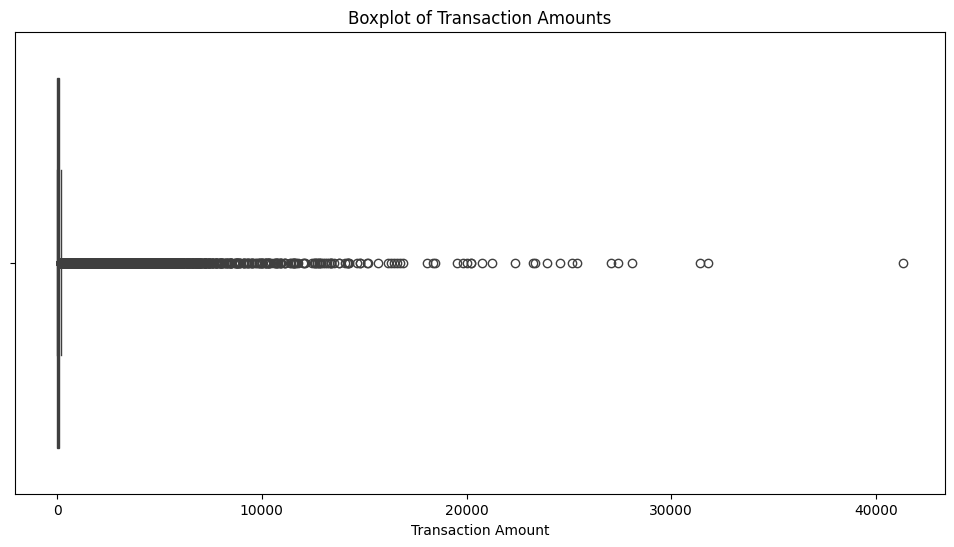

In [78]:
# Detect outliers in the 'amt' column
plt.figure(figsize=(12, 6))
sns.boxplot(x=merged_df['amt'])
plt.title('Boxplot of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.show()

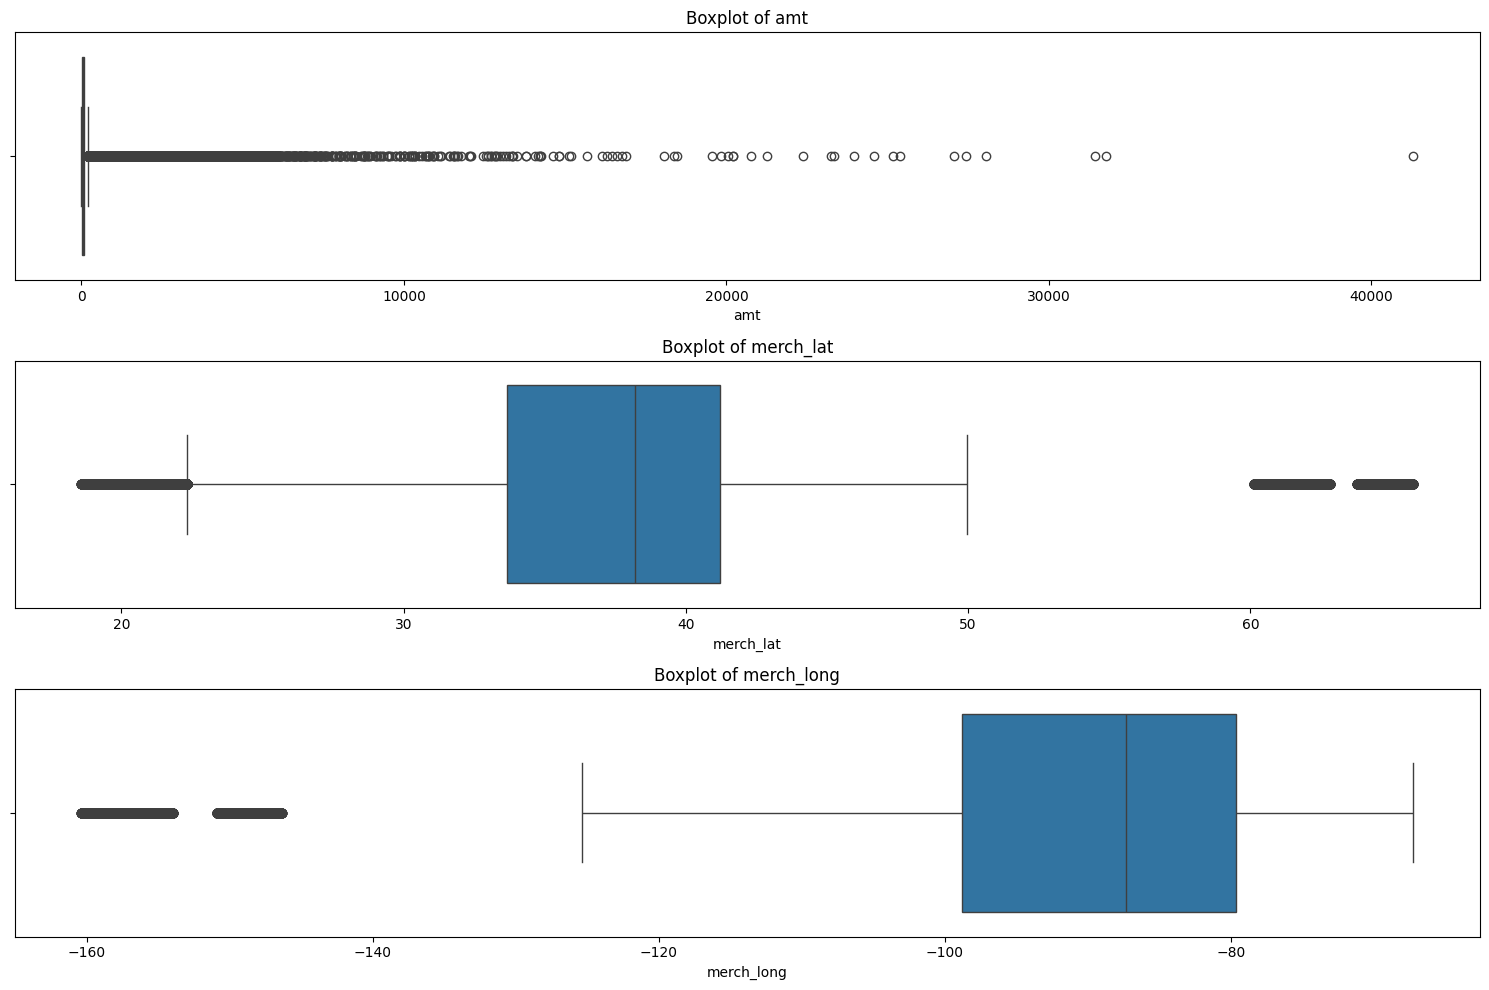

In [79]:
# Boxplots for numerical features
numerical_features = ['amt', 'merch_lat', 'merch_long']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=merged_df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

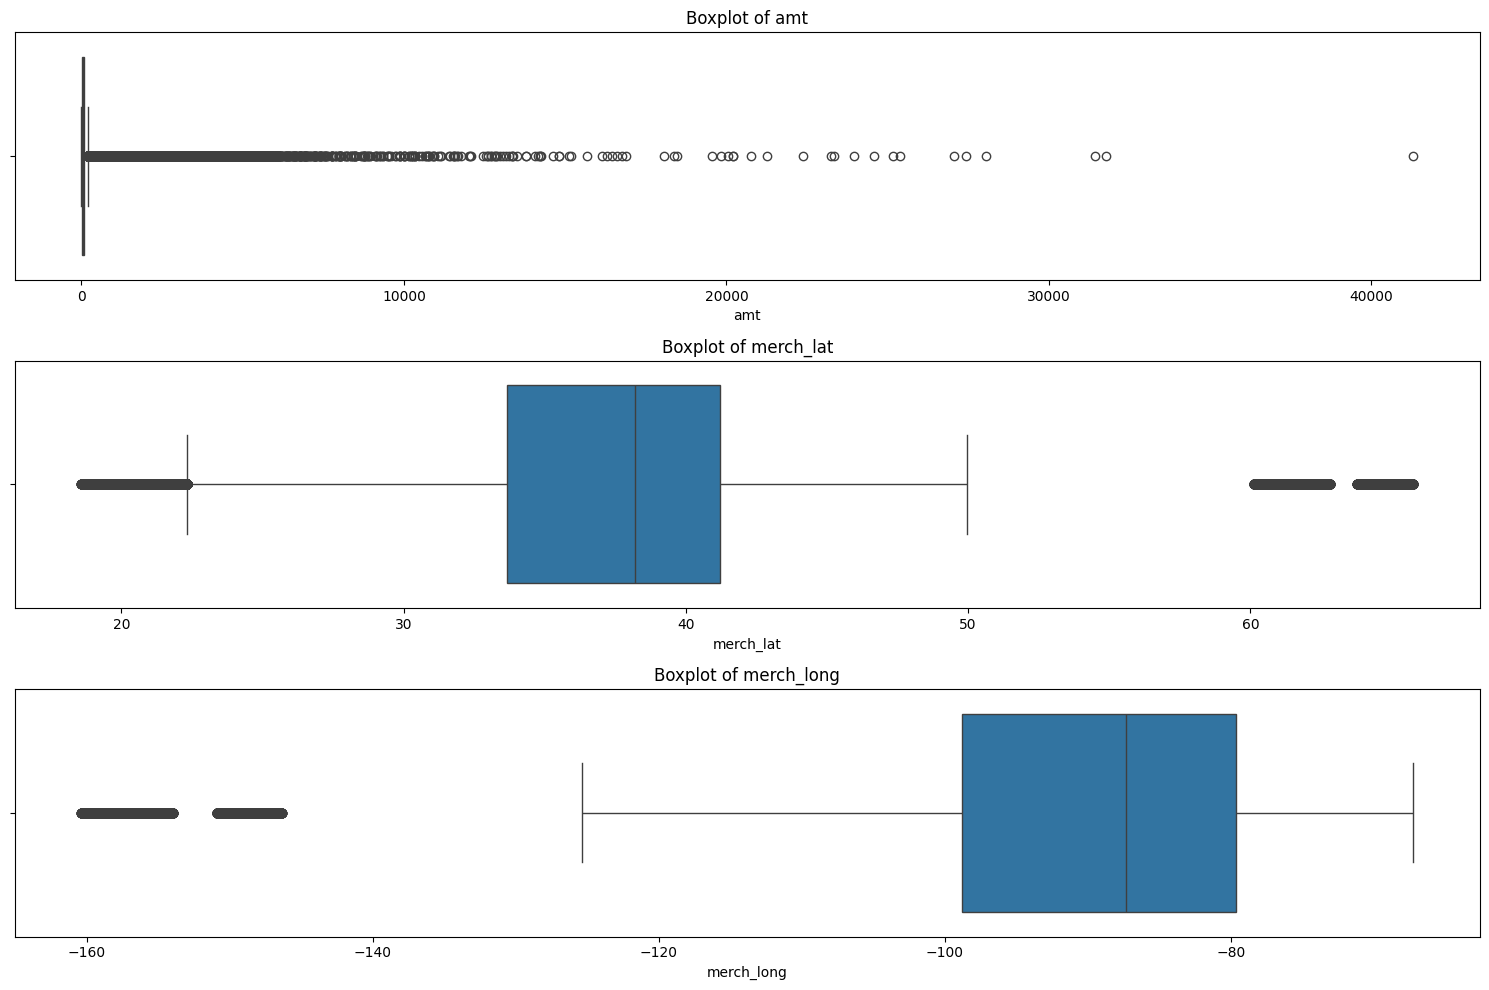

In [80]:
# Boxplots for numerical features
numerical_features = ['amt', 'merch_lat', 'merch_long']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=merged_df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

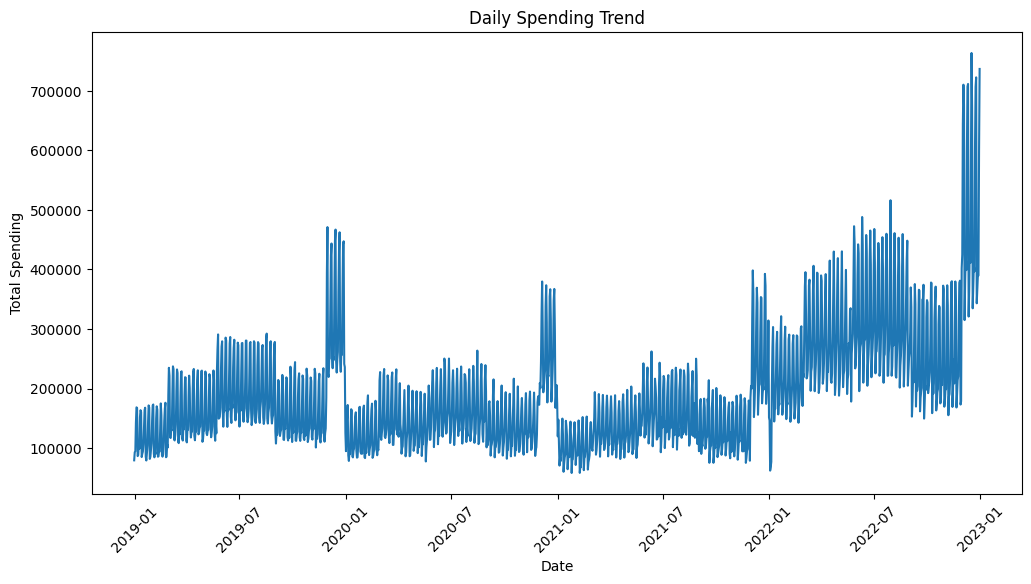

In [81]:
# Time series analysis of transaction amounts
merged_df['transaction_date'] = merged_df['unix_time'].dt.date

# Group by transaction date to get the total spending per day
daily_spending = merged_df.groupby('transaction_date')['amt'].sum().reset_index()

# Plot the daily spending trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_spending, x='transaction_date', y='amt')
plt.title('Daily Spending Trend')
plt.xlabel('Date')
plt.ylabel('Total Spending')
plt.xticks(rotation=45)
plt.show()

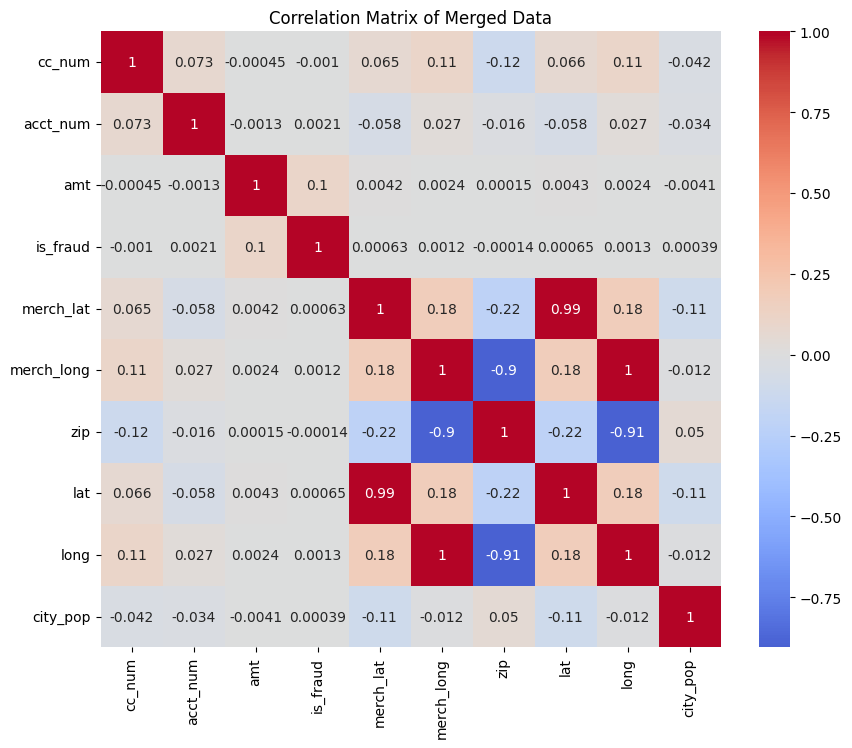

In [82]:
# Select only numeric columns for correlation analysis
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns

# Correlation matrix for numerical features
correlation_matrix = merged_df[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Merged Data')
plt.show()

### 5. Prepare Data

In [7]:
# Convert Unix timestamps to datetime objects
merged_df['datetime'] = pd.to_datetime(merged_df['unix_time'], unit='s', errors='coerce')

# Extract year, month, day, hour, minute, and second
merged_df['year'] = merged_df['datetime'].dt.year
merged_df['month'] = merged_df['datetime'].dt.month
merged_df['day'] = merged_df['datetime'].dt.day
merged_df['hour'] = merged_df['datetime'].dt.hour
merged_df['minute'] = merged_df['datetime'].dt.minute
merged_df['second'] = merged_df['datetime'].dt.second

# Display the first few rows to verify
print(merged_df.head())

               cc_num      acct_num                         trans_num  \
1998358  2.131404e+14  2.801736e+11  a410f9d17a82d616d248d0e65c58420f   
3498426  3.728535e+14  4.678466e+11  bf3e9ab9554652fcd8e0a50ba8dd1d91   
675823   5.719453e+11  4.101953e+10  ba8e37ae12a9b7fe62ed317523c1b702   
563134   6.763059e+11  6.613849e+11  f303afd08e32a5046250692754d73c6c   
1307267  4.317303e+15  3.822127e+11  d5151f4de46798370c91865d3836bd08   

                  unix_time       category     amt  is_fraud  \
1998358 2018-12-31 13:00:48  gas_transport  209.83       0.0   
3498426 2018-12-31 13:00:48  gas_transport    9.53       0.0   
675823  2018-12-31 13:00:48  gas_transport  110.47       0.0   
563134  2018-12-31 13:02:56  gas_transport  199.74       0.0   
1307267 2018-12-31 13:05:04  gas_transport    1.41       0.0   

                          merchant  merch_lat  merch_long  ... city_pop  \
1998358               Peterson LLC  39.665260  -76.774664  ...   213013   
3498426             Trujil

In [8]:
# Label encoding for categorical variables
le_category = LabelEncoder()
merged_df['category_encoded'] = le_category.fit_transform(merged_df['category'])

le_job = LabelEncoder()
merged_df['job_encoded'] = le_job.fit_transform(merged_df['job'])

le_dob = LabelEncoder()
merged_df['dob_encoded'] = le_dob.fit_transform(merged_df['dob'])

# Now we have all numeric features
features = [
    'cc_num', 'acct_num', 'is_fraud', 'merch_lat', 'merch_long',
    'year', 'month', 'day', 'hour', 'minute', 'second',
    'category_encoded', 'job_encoded', 'dob_encoded'
]
X = merged_df[features]
y = merged_df['amt']

In [9]:
# Compute mutual information
mi = mutual_info_regression(X, y)

# Print information gain values
print("Information Gain values for features:")
for feature, value in zip(X.columns, mi):
    print(f"{feature}: {value}")

Information Gain values for features:
cc_num: 0.014631554732499552
acct_num: 0.04484153578576322
is_fraud: 0.0038618984125715627
merch_lat: 0.0008028861092110873
merch_long: 0.0030608351817509316
year: 0.02727387973916784
month: 0.00521068288798876
day: 0.00012686011168927536
hour: 0.03941076331097815
minute: 0.0019896467480755575
second: 0.0
category_encoded: 0.04520523093448148
job_encoded: 0.028383782539640023
dob_encoded: 0.04719613255475785


In [10]:
# Select top features based on information gain
top_features = [feature for feature, value in sorted(zip(X.columns, mi), key=lambda x: x[1], reverse=True)[:7]]

# Define features and target variable
X = merged_df[top_features]
y = merged_df['amt']

### 6. Split Dataset

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3286706, 7)
y_train shape: (3286706,)
X_test shape: (821677, 7)
y_test shape: (821677,)


### 7. Baseline Model

In [12]:
# Baseline model using the mean of the 'amt' from the training set
baseline_pred = np.full_like(y_test, y_train.mean())

# Calculate RMSE and R2 for the baseline model
baseline_rmse = sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print("Baseline Model - Test RMSE:", baseline_rmse)
print("Baseline Model - Test R2:", baseline_r2)

Baseline Model - Test RMSE: 154.31096715737746
Baseline Model - Test R2: -5.76031395094212e-06


### 8. Train Machine Learning Model

#### Experiment 1: Linear Regression

In [13]:
# Train the Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict on training set
y_train_pred_lr = model_lr.predict(X_train)
train_rmse_lr = sqrt(mean_squared_error(y_train, y_train_pred_lr))
train_r2_lr = r2_score(y_train, y_train_pred_lr)

# Predict on test set
y_test_pred_lr = model_lr.predict(X_test)
test_rmse_lr = sqrt(mean_squared_error(y_test, y_test_pred_lr))
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print("Linear Regression - Train RMSE:", train_rmse_lr)
print("Linear Regression - Train R2:", train_r2_lr)
print("Linear Regression - Test RMSE:", test_rmse_lr)
print("Linear Regression - Test R2:", test_r2_lr)

Linear Regression - Train RMSE: 163.37337837147336
Linear Regression - Train R2: 3.213037172766775e-06
Linear Regression - Test RMSE: 154.31093027840242
Linear Regression - Test R2: -5.2823287017833565e-06


#### Experiment 2: Ridge Regression

In [14]:
# Train the Ridge Regression model
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)

# Predict on training set
y_train_pred_ridge = model_ridge.predict(X_train)
train_rmse_ridge = sqrt(mean_squared_error(y_train, y_train_pred_ridge))
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)

# Predict on test set
y_test_pred_ridge = model_ridge.predict(X_test)
test_rmse_ridge = sqrt(mean_squared_error(y_test, y_test_pred_ridge))
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

print("Ridge Regression - Train RMSE:", train_rmse_ridge)
print("Ridge Regression - Train R2:", train_r2_ridge)
print("Ridge Regression - Test RMSE:", test_rmse_ridge)
print("Ridge Regression - Test R2:", test_r2_ridge)

Ridge Regression - Train RMSE: 163.2904589774963
Ridge Regression - Train R2: 0.001018042818777154
Ridge Regression - Test RMSE: 154.21094969698768
Ridge Regression - Test R2: 0.001290137505327582


#### Experiment 3: Lasso Regression

In [15]:
# Train the Lasso Regression model
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train, y_train)

# Predict on training set
y_train_pred_lasso = model_lasso.predict(X_train)
train_rmse_lasso = sqrt(mean_squared_error(y_train, y_train_pred_lasso))
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)

# Predict on test set
y_test_pred_lasso = model_lasso.predict(X_test)
test_rmse_lasso = sqrt(mean_squared_error(y_test, y_test_pred_lasso))
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

print("Lasso Regression - Train RMSE:", train_rmse_lasso)
print("Lasso Regression - Train R2:", train_r2_lasso)
print("Lasso Regression - Test RMSE:", test_rmse_lasso)
print("Lasso Regression - Test R2:", test_r2_lasso)

Lasso Regression - Train RMSE: 163.29048684146915
Lasso Regression - Train R2: 0.0010177018850975328
Lasso Regression - Test RMSE: 154.21118170700396
Lasso Regression - Test R2: 0.00128713238972189


#### Experiment 4: ElasticNet Regression

In [16]:
# Train the ElasticNet Regression model
model_enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
model_enet.fit(X_train, y_train)

# Predict on training set
y_train_pred_enet = model_enet.predict(X_train)
train_rmse_enet = sqrt(mean_squared_error(y_train, y_train_pred_enet))
train_r2_enet = r2_score(y_train, y_train_pred_enet)

# Predict on test set
y_test_pred_enet = model_enet.predict(X_test)
test_rmse_enet = sqrt(mean_squared_error(y_test, y_test_pred_enet))
test_r2_enet = r2_score(y_test, y_test_pred_enet)

print("ElasticNet Regression - Train RMSE:", train_rmse_enet)
print("ElasticNet Regression - Train R2:", train_r2_enet)
print("ElasticNet Regression - Test RMSE:", test_rmse_enet)
print("ElasticNet Regression - Test R2:", test_r2_enet)

ElasticNet Regression - Train RMSE: 163.29052837482908
ElasticNet Regression - Train R2: 0.0010171936975424956
ElasticNet Regression - Test RMSE: 154.21123781981214
ElasticNet Regression - Test R2: 0.0012864055864754143


#### Experiment 5: Polynomial Regression

In [17]:
# Apply polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the Polynomial Regression model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Predict on training set
y_train_pred_poly = model_poly.predict(X_train_poly)
train_rmse_poly = sqrt(mean_squared_error(y_train, y_train_pred_poly))
train_r2_poly = r2_score(y_train, y_train_pred_poly)

# Predict on test set
y_test_pred_poly = model_poly.predict(X_test_poly)
test_rmse_poly = sqrt(mean_squared_error(y_test, y_test_pred_poly))
test_r2_poly = r2_score(y_test, y_test_pred_poly)

print("Polynomial Regression - Train RMSE:", train_rmse_poly)
print("Polynomial Regression - Train R2:", train_r2_poly)
print("Polynomial Regression - Test RMSE:", test_rmse_poly)
print("Polynomial Regression - Test R2:", test_r2_poly)

Polynomial Regression - Train RMSE: 163.37345292989122
Polynomial Regression - Train R2: 2.3003034576030146e-06
Polynomial Regression - Test RMSE: 154.31111771225355
Polynomial Regression - Test R2: -7.711644042007748e-06


### 9. Assess Model Performance

In [18]:
# Store the performance metrics in dictionaries
rmse_scores = {
    "Baseline": baseline_rmse,
    "Linear Regression": test_rmse_lr,
    "Ridge Regression": test_rmse_ridge,
    "Lasso Regression": test_rmse_lasso,
    "ElasticNet Regression": test_rmse_enet,
    "Polynomial Regression": test_rmse_poly
}

r2_scores = {
    "Baseline": baseline_r2,
    "Linear Regression": test_r2_lr,
    "Ridge Regression": test_r2_ridge,
    "Lasso Regression": test_r2_lasso,
    "ElasticNet Regression": test_r2_enet,
    "Polynomial Regression": test_r2_poly
}

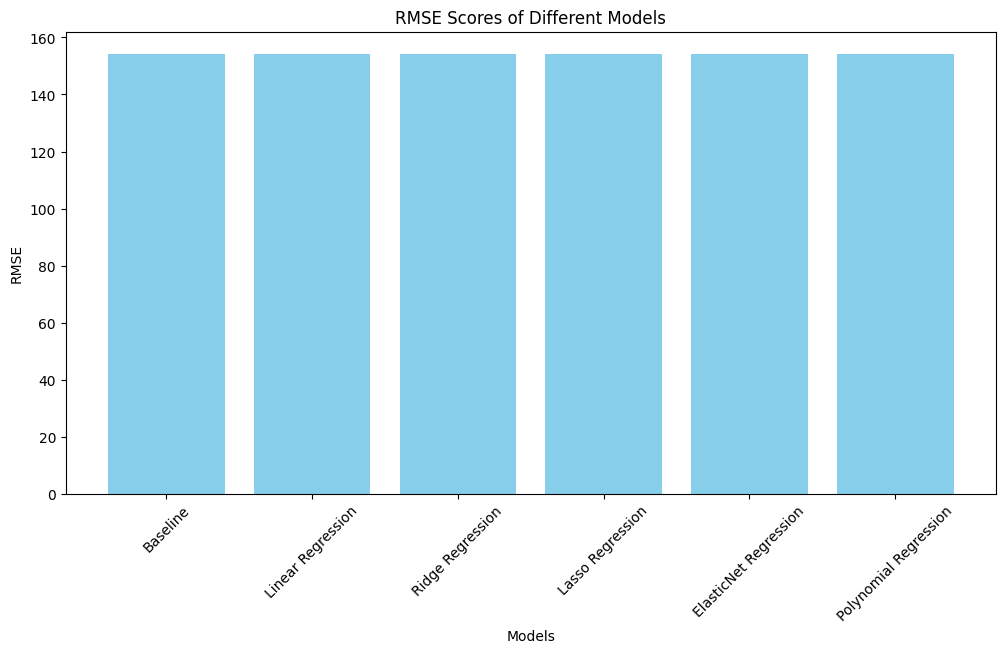

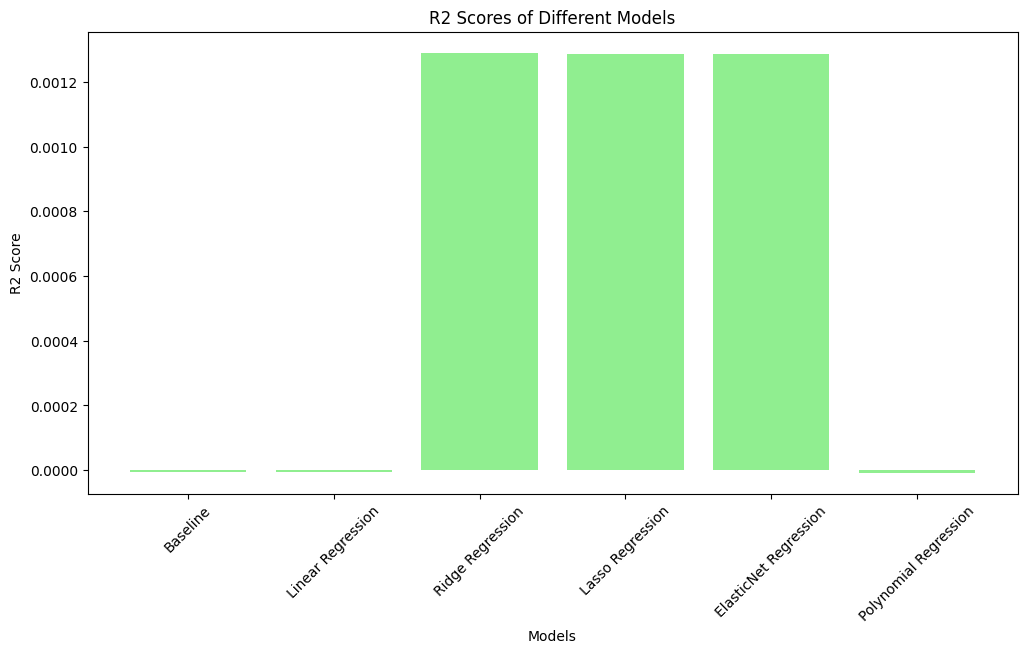

In [19]:
# Plot RMSE scores
plt.figure(figsize=(12, 6))
plt.bar(rmse_scores.keys(), rmse_scores.values(), color='skyblue')
plt.title('RMSE Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

# Plot R2 scores
plt.figure(figsize=(12, 6))
plt.bar(r2_scores.keys(), r2_scores.values(), color='lightgreen')
plt.title('R2 Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.show()